In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder as le

# ML libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [2]:
US_train_df = pd.read_csv("us_states_covid19_daily.csv")
date_to_count = pd.read_csv("date_to_count.csv")

In [3]:
US_train_df.head(10)

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200425,AK,339.0,15393.0,NaN,32.0,NaN,NaN,NaN,NaN,...,NaN,15732.0,15732.0,15732.0,2,0.0,0.0,3451.0,0.0,3451.0
1,20200425,AL,6137.0,65207.0,NaN,NaN,839.0,NaN,288.0,NaN,...,839.0,71344.0,71344.0,71344.0,1,15.0,71.0,18344.0,305.0,18649.0
2,20200425,AR,2829.0,35224.0,NaN,104.0,291.0,NaN,NaN,25.0,...,291.0,38053.0,38053.0,38053.0,5,2.0,0.0,2387.0,88.0,2475.0
3,20200425,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200425,AZ,6280.0,56228.0,NaN,697.0,1022.0,313.0,NaN,191.0,...,1022.0,62508.0,62508.0,62508.0,4,0.0,38.0,1559.0,235.0,1794.0
5,20200425,CA,41137.0,464898.0,NaN,4847.0,NaN,1458.0,NaN,NaN,...,NaN,506035.0,506035.0,506035.0,6,89.0,0.0,9979.0,1883.0,11862.0
6,20200425,CO,12256.0,44533.0,NaN,1084.0,2366.0,NaN,NaN,NaN,...,2366.0,56789.0,56789.0,56789.0,8,122.0,129.0,3471.0,994.0,4465.0
7,20200425,CT,24582.0,53020.0,NaN,1810.0,NaN,NaN,NaN,NaN,...,NaN,77602.0,77602.0,77602.0,9,98.0,0.0,2903.0,661.0,3564.0
8,20200425,DC,3699.0,13603.0,NaN,402.0,NaN,120.0,NaN,69.0,...,NaN,17302.0,17302.0,17302.0,11,12.0,0.0,598.0,171.0,769.0
9,20200425,DE,3576.0,14122.0,NaN,300.0,NaN,NaN,NaN,NaN,...,NaN,17698.0,17698.0,17698.0,10,12.0,0.0,185.0,134.0,319.0


In [4]:
display(US_train_df.isnull().sum())

date                           0
state                          0
positive                      15
negative                     193
pending                     2256
hospitalizedCurrently       2019
hospitalizedCumulative      1896
inIcuCurrently              2451
inIcuCumulative             2709
onVentilatorCurrently       2541
onVentilatorCumulative      2828
recovered                   2132
hash                           0
dateChecked                    0
death                        739
hospitalized                1896
total                          2
totalTestResults               2
posNeg                         2
fips                           0
deathIncrease                 56
hospitalizedIncrease          56
negativeIncrease              56
positiveIncrease              56
totalTestResultsIncrease      56
dtype: int64

In [5]:
display(US_train_df.isnull().sum()/len(US_train_df)*100)

date                         0.000000
state                        0.000000
positive                     0.520653
negative                     6.699063
pending                     78.306144
hospitalizedCurrently       70.079833
hospitalizedCumulative      65.810482
inIcuCurrently              85.074627
inIcuCumulative             94.029851
onVentilatorCurrently       88.198542
onVentilatorCumulative      98.160361
recovered                   74.002083
hash                         0.000000
dateChecked                  0.000000
death                       25.650816
hospitalized                65.810482
total                        0.069420
totalTestResults             0.069420
posNeg                       0.069420
fips                         0.000000
deathIncrease                1.943770
hospitalizedIncrease         1.943770
negativeIncrease             1.943770
positiveIncrease             1.943770
totalTestResultsIncrease     1.943770
dtype: float64

In [6]:
df_confirmedcases = US_train_df.groupby(['state']).max().groupby('state').sum().sort_values(by='positive', ascending=False).reset_index()
df_confirmedcases.set_index('state').style.background_gradient(cmap='Oranges')

,date,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
state,,,,,,,,,,,,,,,,,,,,,,
NY,20200425,282143,495425,236,18825,57103,5225,0,0,0,23887,16599,57103,777568,777568,777568,36,799,4249,36359,11571,46912
NJ,20200425,105523,108163,94,8270,0,2051,0,1705,0,682,5863,0,213686,213686,213686,34,376,0,7966,4305,10305
MA,20200425,53348,173497,0,3977,4965,1058,0,0,0,0,2730,4965,226845,226845,226845,25,370,4493,24444,7325,31769
IL,20200425,41777,159840,195,4877,0,1268,0,821,0,0,1874,0,201617,201617,201617,17,125,0,13592,2724,16316
CA,20200425,41137,464898,64400,5236,0,1591,0,0,0,0,1651,0,506035,506035,506035,6,115,0,163092,2322,165227
PA,20200425,40049,152886,183,2764,1145,0,0,685,0,0,1622,1145,192935,192935,192935,42,360,241,6318,2005,7915
MI,20200425,37203,106841,30,3986,0,1663,0,1441,0,8342,3274,0,144044,144044,144044,26,232,0,9301,1366,10096
FL,20200425,30839,302260,1789,0,5045,0,0,0,0,0,1075,5045,334391,333099,333099,12,72,317,18909,1575,20251
LA,20200425,26512,117576,0,2134,0,0,0,571,0,14927,1644,0,143716,143716,143716,22,129,0,9829,2726,10331


In [7]:
US_train_df_new = US_train_df[['state', 'date', 'positive', 'negative', 'recovered', 'death', 'hospitalized']].copy()
US_train_df_new.head()

,state,date,positive,negative,recovered,death,hospitalized
0,AK,20200425,339.0,15393.0,217.0,9.0,NaN
1,AL,20200425,6137.0,65207.0,NaN,212.0,839.0
2,AR,20200425,2829.0,35224.0,964.0,47.0,291.0
3,AS,20200425,0.0,3.0,NaN,0.0,NaN
4,AZ,20200425,6280.0,56228.0,1345.0,266.0,1022.0


In [8]:
df_confirmedcases = US_train_df_new.groupby(['state']).max().groupby('state').sum().sort_values(by='positive', ascending=False).reset_index()
df_confirmedcases.set_index('state').style.background_gradient(cmap='Reds')

,date,positive,negative,recovered,death,hospitalized
state,,,,,,
NY,20200425,282143,495425,23887,16599,57103
NJ,20200425,105523,108163,682,5863,0
MA,20200425,53348,173497,0,2730,4965
IL,20200425,41777,159840,0,1874,0
CA,20200425,41137,464898,0,1651,0
PA,20200425,40049,152886,0,1622,1145
MI,20200425,37203,106841,8342,3274,0
FL,20200425,30839,302260,0,1075,5045
LA,20200425,26512,117576,14927,1644,0


In [13]:
deathRate = US_train_df_new['death']/US_train_df_new['positive']
deathRate.shape
US_train_df_new.shape

(2881, 7)

In [14]:
US_train_df_new['deathRate'] = deathRate
US_train_df_new.head()

,state,date,positive,negative,recovered,death,hospitalized,deathRate
0,AK,20200425,339.0,15393.0,217.0,9.0,NaN,0.026549
1,AL,20200425,6137.0,65207.0,NaN,212.0,839.0,0.034545
2,AR,20200425,2829.0,35224.0,964.0,47.0,291.0,0.016614
3,AS,20200425,0.0,3.0,NaN,0.0,NaN,NaN
4,AZ,20200425,6280.0,56228.0,1345.0,266.0,1022.0,0.042357


In [15]:
df_confirmedcases = US_train_df_new.groupby(['state']).max().groupby('state').sum().sort_values(by='deathRate', ascending=False).reset_index()
df_confirmedcases.set_index('state').style.background_gradient(cmap='Blues')

,date,positive,negative,recovered,death,hospitalized,deathRate
state,,,,,,,
WA,20200425,12977,147347,0,723,0,0.444444
MP,20200425,14,51,11,2,0,0.25
KS,20200425,3056,22143,0,117,474,0.166667
SD,20200425,2147,13449,1223,10,128,0.0909091
MI,20200425,37203,106841,8342,3274,0,0.0880037
CT,20200425,24582,53020,0,1862,0,0.0757465
PR,20200425,1307,9313,0,83,0,0.0754098
VT,20200425,843,13839,1710,46,50,0.0736842
FL,20200425,30839,302260,0,1075,5045,0.0714286


In [17]:
US_train_df_new.fillna(0, inplace=True)

In [18]:
US_train_df_new['date'] = pd.to_datetime(US_train_df_new['date'], yearfirst=True, format='%Y%m%d')
US_train_df_new.head()

,state,date,positive,negative,recovered,death,hospitalized,deathRate
0,AK,2020-04-25,339.0,15393.0,217.0,9.0,0.0,0.026549
1,AL,2020-04-25,6137.0,65207.0,0.0,212.0,839.0,0.034545
2,AR,2020-04-25,2829.0,35224.0,964.0,47.0,291.0,0.016614
3,AS,2020-04-25,0.0,3.0,0.0,0.0,0.0,0.000000
4,AZ,2020-04-25,6280.0,56228.0,1345.0,266.0,1022.0,0.042357


In [19]:
US_train_df_new['date'].dtype

dtype('<M8[ns]')

In [20]:
state_features = pd.read_csv("addtl_state_features.csv")
state_features.head()

,state,Primaries,Population Size,Climate
0,AL,in-person primary March,4903185,humid subtropical
1,AK,in-person primary April,731545,subarctic
2,AS,in-person primary March,55312,tropical rainforest
3,AZ,in-person primary March,7278717,hot desert
4,AR,in-person primary March,3017804,humid subtropical


In [21]:
state_features = state_features.set_index('state')

In [22]:
US_train_df_new = US_train_df_new.set_index('state')

In [23]:
# Merge the two Dataframes on state index of both
mergedDf = US_train_df_new.merge(state_features, left_index=True, right_index=True)

In [24]:
mergedDf.head()

,date,positive,negative,recovered,death,hospitalized,deathRate,Primaries,Population Size,Climate
state,,,,,,,,,,
AK,2020-04-25,339.0,15393.0,217.0,9.0,0.0,0.026549,in-person primary April,731545,subarctic
AK,2020-04-24,339.0,11942.0,208.0,9.0,0.0,0.026549,in-person primary April,731545,subarctic
AK,2020-04-23,337.0,11824.0,209.0,9.0,0.0,0.026706,in-person primary April,731545,subarctic
AK,2020-04-22,335.0,11824.0,196.0,9.0,36.0,0.026866,in-person primary April,731545,subarctic
AK,2020-04-21,329.0,10790.0,168.0,9.0,36.0,0.027356,in-person primary April,731545,subarctic


In [25]:
mergedDf = mergedDf.reset_index()
mergedDf.head()

,state,date,positive,negative,recovered,death,hospitalized,deathRate,Primaries,Population Size,Climate
0,AK,2020-04-25,339.0,15393.0,217.0,9.0,0.0,0.026549,in-person primary April,731545,subarctic
1,AK,2020-04-24,339.0,11942.0,208.0,9.0,0.0,0.026549,in-person primary April,731545,subarctic
2,AK,2020-04-23,337.0,11824.0,209.0,9.0,0.0,0.026706,in-person primary April,731545,subarctic
3,AK,2020-04-22,335.0,11824.0,196.0,9.0,36.0,0.026866,in-person primary April,731545,subarctic
4,AK,2020-04-21,329.0,10790.0,168.0,9.0,36.0,0.027356,in-person primary April,731545,subarctic


In [26]:
mergedDf = mergedDf.assign(ID=[2881 - i for i in range(len(mergedDf))])[['ID'] + mergedDf.columns.tolist()]
mergedDf.tail()

,ID,state,date,positive,negative,recovered,death,hospitalized,deathRate,Primaries,Population Size,Climate
2876,5,WY,2020-03-11,0.0,0.0,0.0,0.0,0.0,0.0,in-person primary cancelled,578759,cold semi-arid mediterranean continental
2877,4,WY,2020-03-10,0.0,0.0,0.0,0.0,0.0,0.0,in-person primary cancelled,578759,cold semi-arid mediterranean continental
2878,3,WY,2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,in-person primary cancelled,578759,cold semi-arid mediterranean continental
2879,2,WY,2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,in-person primary cancelled,578759,cold semi-arid mediterranean continental
2880,1,WY,2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,in-person primary cancelled,578759,cold semi-arid mediterranean continental


In [27]:
date_to_count.head()

,Date,Day_num
0,2020-01-22,1
1,2020-01-23,2
2,2020-01-24,3
3,2020-01-25,4
4,2020-01-26,5


In [28]:
date_to_count = date_to_count.set_index('Date')

In [29]:
mergedDf = mergedDf.set_index('date')

In [30]:
# Merge the two Dataframes on date index of both
train_df_all = mergedDf.merge(date_to_count, left_index=True, right_index=True)

In [31]:
train_df_all.head()

,ID,state,positive,negative,recovered,death,hospitalized,deathRate,Primaries,Population Size,Climate,Day_num
2020-01-22,155,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,1
2020-01-23,156,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,2
2020-01-24,157,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,3
2020-01-25,158,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,4
2020-01-26,159,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,5


In [32]:
train_df_all = train_df_all.reset_index()
train_df_all.head()

,index,ID,state,positive,negative,recovered,death,hospitalized,deathRate,Primaries,Population Size,Climate,Day_num
0,2020-01-22,155,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,1
1,2020-01-23,156,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,2
2,2020-01-24,157,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,3
3,2020-01-25,158,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,4
4,2020-01-26,159,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,5


In [33]:
train_df_all = train_df_all.rename(columns={'index': 'Date'})
train_df_all.head(3)

,Date,ID,state,positive,negative,recovered,death,hospitalized,deathRate,Primaries,Population Size,Climate,Day_num
0,2020-01-22,155,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,1
1,2020-01-23,156,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,2
2,2020-01-24,157,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,3


In [34]:
train_df_all['Day_num'].max()

95

In [35]:
df_all = pd.read_csv("/Users/farneysk/Documents/Machine_Learning_Class/biof509/final-project/US_covid19_daily_revised.csv")

In [36]:
display(df_all.head(5))
display(df_all.describe())
print("Number of States: ", df_all['state'].nunique())
print("Dates range from day", min(df_all['Date']), "to day", max(df_all['Date']), 
      ", a total of", df_all['Date'].nunique(), "days")

,Unnamed: 0,Date,ID,state,positive,negative,recovered,death,hospitalized,deathRate,Primaries,Population Size,Climate,Day_num
0,0,2020-01-22,2727,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,1
1,1,2020-01-23,2726,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,2
2,2,2020-01-24,2725,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,3
3,3,2020-01-25,2724,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,4
4,4,2020-01-26,2723,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,5


,Unnamed: 0,ID,positive,negative,recovered,death,hospitalized,deathRate,Population Size,Day_num
count,2881.000000,2881.000000,2881.000000,2881.000000,2881.000000,2881.000000,2881.000000,2881.000000,2.881000e+03,2881.000000
mean,1440.000000,1441.000000,5362.310309,23043.992711,334.129816,220.738980,585.180146,0.021150,6.123252e+06,69.334259
std,831.817388,831.817388,20384.635140,46853.317776,2004.427371,1075.676999,4172.587355,0.026462,7.198627e+06,15.876335
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.199400e+04,1.000000
25%,720.000000,721.000000,31.000000,190.000000,0.000000,0.000000,0.000000,0.000000,1.359711e+06,57.000000
50%,1440.000000,1441.000000,460.000000,6088.000000,0.000000,8.000000,0.000000,0.018167,4.217737e+06,70.000000
75%,2160.000000,2161.000000,2868.000000,25342.000000,15.000000,79.000000,63.000000,0.031555,7.614893e+06,83.000000
max,2880.000000,2881.000000,282143.000000,495425.000000,23887.000000,16599.000000,57103.000000,0.444444,3.951222e+07,95.000000


Number of States:  56
Dates range from day 2020-01-22 to day 2020-04-25 , a total of 95 days


Text(0.5, 0, 'Date')

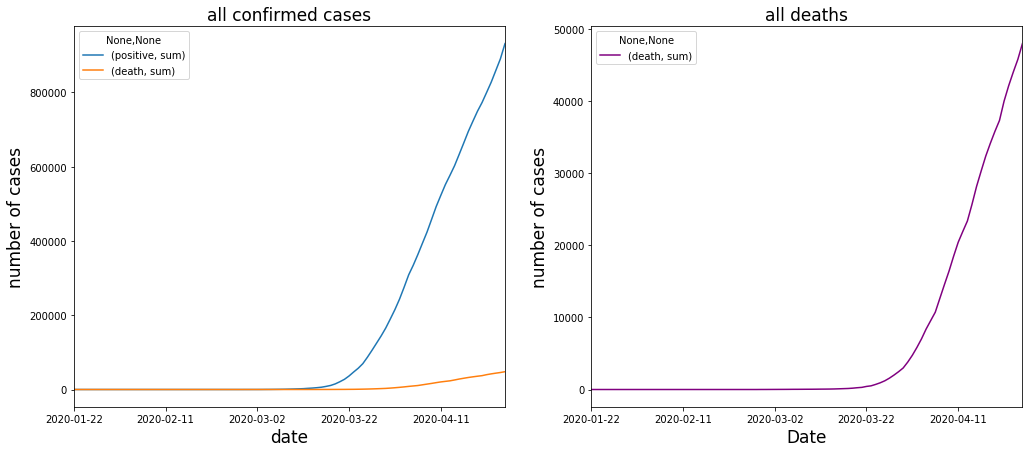

In [38]:
confirmed_total_date = df_all.groupby(['Date']).agg({'positive':['sum']})
fatalities_total_date = df_all.groupby(['Date']).agg({'death':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("all confirmed cases", size=17)
ax1.set_ylabel("number of cases", size=17)
ax1.set_xlabel("date", size=17)
fatalities_total_date.plot(ax=ax2, color='purple')
ax2.set_title("all deaths", size=17)
ax2.set_ylabel("number of cases", size=17)
ax2.set_xlabel("Date", size=17)

In [40]:
confirmed_total_date_Florida = df_all[df_all['state']=='FL'].groupby(['Date']).agg({'positive':['sum']})
fatalities_total_date_Florida = df_all[df_all['state']=='FL'].groupby(['Date']).agg({'death':['sum']})
total_date_Florida = confirmed_total_date_Florida.join(fatalities_total_date_Florida)

confirmed_total_date_California = df_all[df_all['state']=='CA'].groupby(['Date']).agg({'positive':['sum']})
fatalities_total_date_California = df_all[df_all['state']=='CA'].groupby(['Date']).agg({'death':['sum']})
total_date_California = confirmed_total_date_California.join(fatalities_total_date_California)

confirmed_total_date_DC = df_all[df_all['state']=='DC'].groupby(['Date']).agg({'positive':['sum']})
fatalities_total_date_DC = df_all[df_all['state']=='DC'].groupby(['Date']).agg({'death':['sum']})
total_date_DC = confirmed_total_date_DC.join(fatalities_total_date_DC)

confirmed_total_date_Alaska = df_all[df_all['state']=='AK'].groupby(['Date']).agg({'positive':['sum']})
fatalities_total_date_Alaska = df_all[df_all['state']=='AK'].groupby(['Date']).agg({'death':['sum']})
total_date_Alaska = confirmed_total_date_Alaska.join(fatalities_total_date_Alaska)

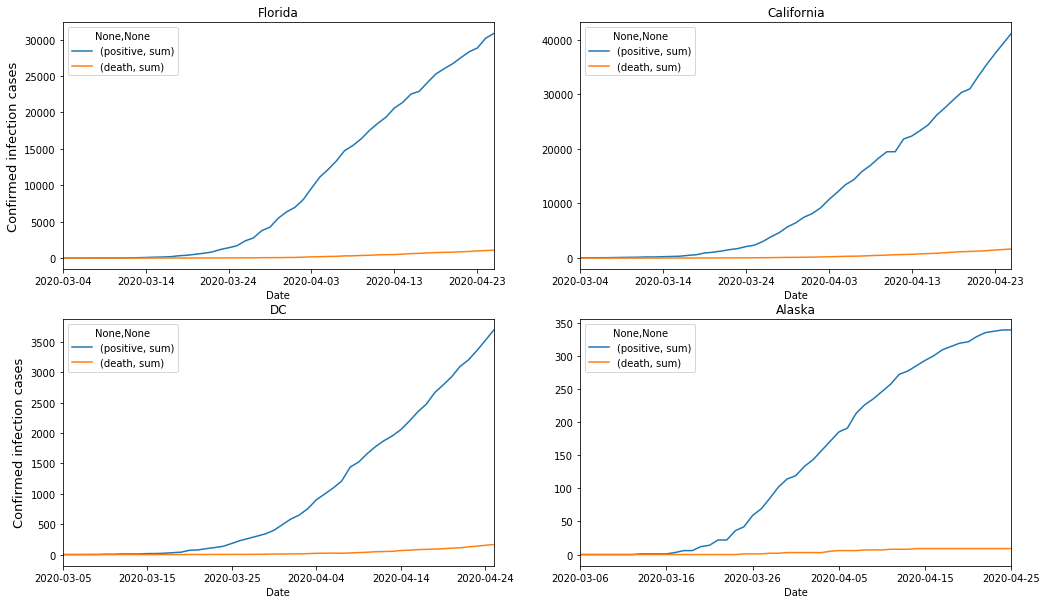

In [41]:
plt.figure(figsize=(17,10))
plt.subplot(2, 2, 1)
total_date_Florida.plot(ax=plt.gca(), title='Florida')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 2)
total_date_California.plot(ax=plt.gca(), title='California')

plt.subplot(2, 2, 3)
total_date_DC.plot(ax=plt.gca(), title='DC')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 4)
total_date_Alaska.plot(ax=plt.gca(), title='Alaska')

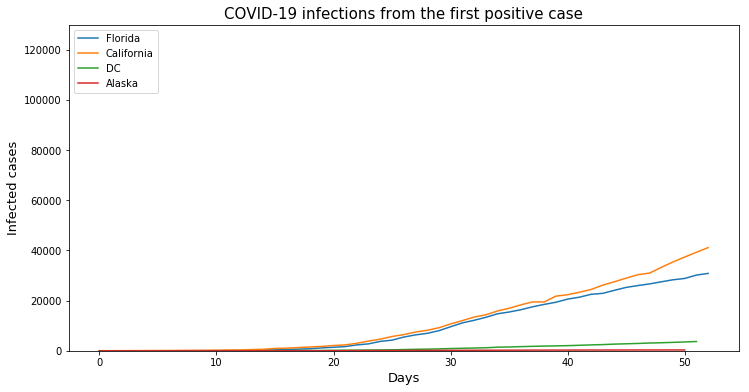

In [42]:
florida = [i for i in total_date_Florida.positive['sum'].values]
florida_30 = florida[0:70] 
california = [i for i in total_date_California.positive['sum'].values]
california_30 = california[0:70] 
DC = [i for i in total_date_DC.positive['sum'].values]
DC_30 = DC[0:70] 
alaska = [i for i in total_date_Alaska.positive['sum'].values]
alaska_30 = alaska[0:70] 


# Plots
plt.figure(figsize=(12,6))
plt.plot(florida_30)
plt.plot(california_30)
plt.plot(DC_30)
plt.plot(alaska_30)
plt.legend(["Florida", "California", "DC", "Alaska"], loc='upper left')
plt.title("COVID-19 infections from the first positive case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 130000)
plt.show()

In [43]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby(['state'])[column].shift(lag, fill_value=0)
    return df

def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df.groupby(['state'])[column].shift(0, fill_value=0) - 
                                df.groupby(['state'])[column].shift(lag, fill_value=0))/df.groupby(['state'])[column].shift(lag, fill_value=0.001)
    return df

In [44]:
# 7 days in lag and 7 forecast days in trend

ts = time.time()
df_all = calculate_lag(df_all.reset_index(), range(1,7), 'positive')
df_all = calculate_lag(df_all, range(1,7), 'death')
df_all = calculate_trend(df_all, range(1,7), 'positive')
df_all = calculate_trend(df_all, range(1,7), 'death')
df_all.replace([np.inf, -np.inf], 0, inplace=True)
df_all.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  0.5132818222045898


Text(0, 0.5, 'Log Positive Cases')

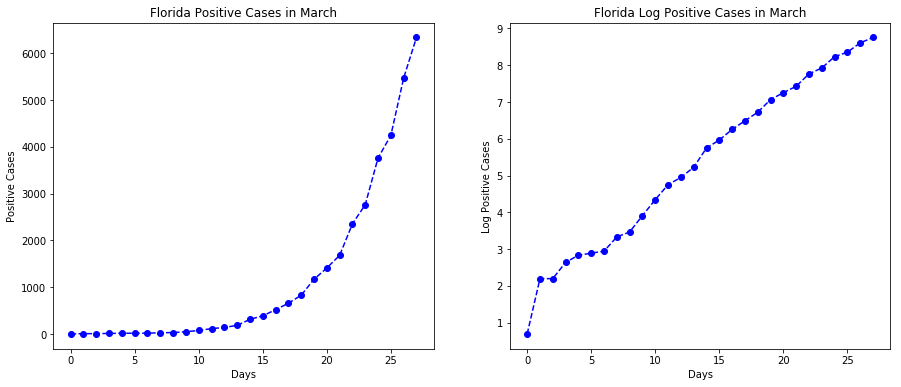

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 40 is March 1st & 70 is March 31st
y1 = df_all[(df_all['state']=='FL') & (df_all['Day_num']>39) & (df_all['Day_num']<=70)][['positive']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Florida Positive Cases in March")
ax1.set_xlabel("Days")
ax1.set_ylabel("Positive Cases")

y2 = df_all[(df_all['state']=='FL') & (df_all['Day_num']>39) & (df_all['Day_num']<=70)][['positive']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Florida Log Positive Cases in March")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log Positive Cases")

Text(0, 0.5, 'Log Positive Cases')

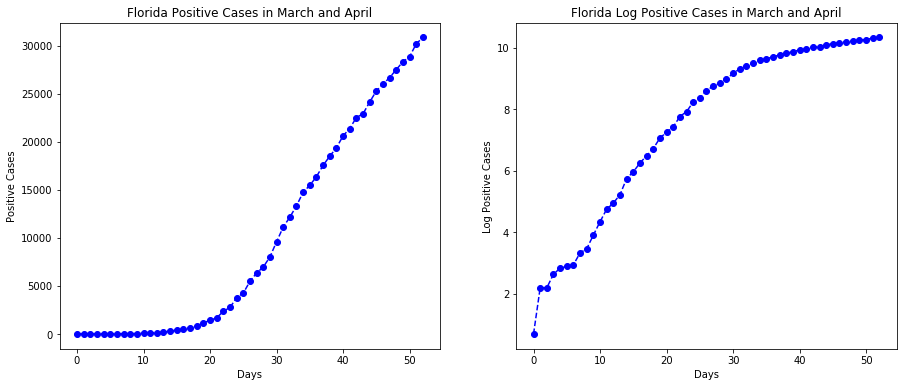

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 40 is March 1st & 95 is April 25th
y1 = df_all[(df_all['state']=='FL') & (df_all['Day_num']>39) & (df_all['Day_num']<=95)][['positive']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Florida Positive Cases in March and April")
ax1.set_xlabel("Days")
ax1.set_ylabel("Positive Cases")

y2 = df_all[(df_all['state']=='FL') & (df_all['Day_num']>39) & (df_all['Day_num']<=95)][['positive']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Florida Log Positive Cases in March and April")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log Positive Cases")

Text(0, 0.5, 'Log Positive Cases')

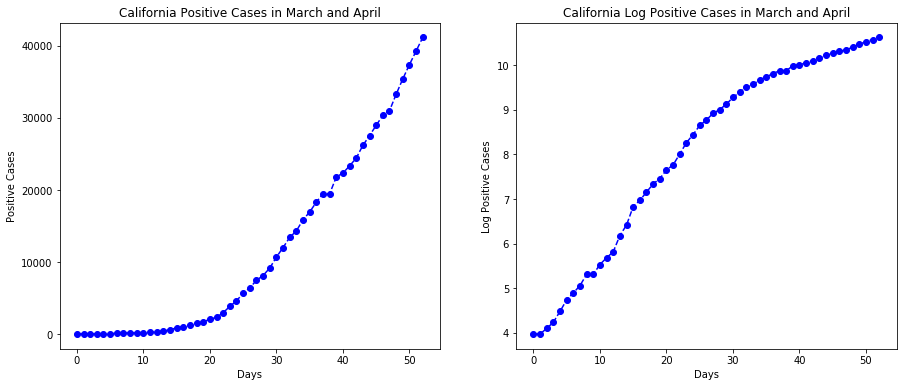

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 40 is March 1st & 95 is April 25th
y1 = df_all[(df_all['state']=='CA') & (df_all['Day_num']>39) & (df_all['Day_num']<=95)][['positive']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("California Positive Cases in March and April")
ax1.set_xlabel("Days")
ax1.set_ylabel("Positive Cases")

y2 = df_all[(df_all['state']=='CA') & (df_all['Day_num']>39) & (df_all['Day_num']<=95)][['positive']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("California Log Positive Cases in March and April")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log Positive Cases")

In [48]:
# Create features
data = df_all.copy()
features = ['ID', 'state', 'positive','negative', 'recovered', 'death', 'deathRate', 'Primaries', 
            'Population Size', 'Climate', 'Day_num']

data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['positive', 'death']] = data[['positive', 'death']].astype('float64')
data[['positive', 'death']] = data[['positive', 'death']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)

In [52]:
train_lim = 39    # train on March
test_lim = 70     # test on April
last_day = 95     # April 25th

In [57]:
X_train_FL = train_set_FL.copy()

In [58]:
from sklearn.preprocessing import StandardScaler

features_FL = ['ID', 'negative', 'recovered', 'death', 'deathRate', 'Population Size', 'Day_num']
# Separating out the features
X = X_train_FL.loc[:, features_FL].values
# Separating out the target
y = X_train_FL.loc[:,['positive']].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

In [59]:
features_all = ['ID', 'negative', 'recovered', 'death', 'deathRate', 'Population Size', 'Day_num']
# Separating out the features
X_df_all = df_all.loc[:, features_all].values
# Separating out the target
y_df_all = df_all.loc[:,['positive']].values
# Standardizing the features
X_df_all = StandardScaler().fit_transform(X_df_all)

In [72]:
df_reload = pd.read_csv("/Users/farneysk/Documents/Machine_Learning_Class/biof509/final-project/US_covid19_daily_revised.csv")
df_reload.head(3)

,Unnamed: 0,Date,ID,state,positive,negative,recovered,death,hospitalized,deathRate,Primaries,Population Size,Climate,Day_num
0,0,2020-01-22,2727,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,1
1,1,2020-01-23,2726,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,2
2,2,2020-01-24,2725,WA,1.0,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,3


In [85]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

np.random.seed(0)

In [116]:
X2 = df_reload.loc[:, ['deathRate']]
y2 = df_reload.positive

#### When modeled using only "death rate" as a feature

In [117]:
cross_val_score(lr, X2, y2, cv=5, scoring='r2').mean()

-1110.118564873774

In [118]:
cross_val_score(lr, X2, y2, cv=5, scoring='neg_mean_squared_error').mean()

-421687958.07596004

In [119]:
X3 = df_reload.drop(['positive', 'Date'], axis=1)

In [120]:
X3.head(2)

,Unnamed: 0,ID,state,negative,recovered,death,hospitalized,deathRate,Primaries,Population Size,Climate,Day_num
0,0,2727,WA,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,1
1,1,2726,WA,0.0,0.0,0.0,0.0,0.0,in-person primary March,7614893,cold semi-arid summer mediterranean,2


In [121]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['state', 'Primaries', 'Climate']), remainder='passthrough')

In [122]:
column_trans.fit_transform(X3)

<2881x88 sparse matrix of type '<class 'numpy.float64'>'
	with 28527 stored elements in Compressed Sparse Row format>

In [123]:
pipe = make_pipeline(column_trans, lr)

#### Using all features available for all dates

In [124]:
cross_val_score(pipe, X3, y2, cv=5, scoring='r2').mean()

-22.214719909435523

In [125]:
cross_val_score(pipe, X3, y2, cv=5, scoring='neg_mean_squared_error').mean()

-45469023.426311076

###      Train model on all states and split data on March 31st
####      Train on January - March
####      Test on April

In [126]:
X3_train = X3[(X3['Day_num']>39) & (X3['Day_num']<=70)]
X3_test = X3[(X3['Day_num']>70) & (X3['Day_num']<=95)]

In [127]:
y3_all = df_reload.copy()
y3_train = y3_all[(y3_all['Day_num']>39) & (df_reload['Day_num']<=70)]
y3_train = y3_train.positive
y3_test = y3_all[(y3_all['Day_num']>70) & (df_reload['Day_num']<=95)]
y3_test = y3_test.positive

In [129]:
r2_feat = cross_val_score(pipe, X3_train, y3_train, cv=5, scoring='r2').mean()
r2_feat

-1.9455016173793953

In [93]:
pipe.fit(X3_train, y3_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['state', 'Primaries',
                      

In [94]:
pipe.predict(X3_test)

array([  423.43896172,  1210.26025362,   809.29443789, ...,
       15717.86861663,  -581.38278277, -1286.0855791 ])

In [95]:
predictions = pipe.predict(X3_test)
actual = y3_test

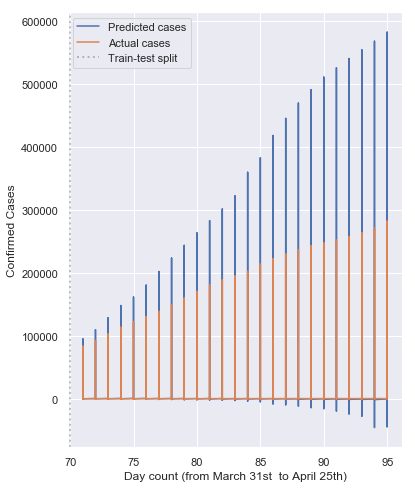

In [145]:
day_num = X3_test['Day_num']
#actual = y3_test
#predictions = X3_test
    
sns.set(style="darkgrid")
plt.figure(figsize=(6, 8))
ax = plt.axes()
ax.plot(day_num, predictions)
ax.plot(day_num, actual)
ax.axvline(70, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax.set_xlabel("Day count (from March 31st " + " to April 25th)")
ax.set_ylabel("Confirmed Cases");


# Put the legend out of the figure
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#ax.axis('tight')
#plt.show()    

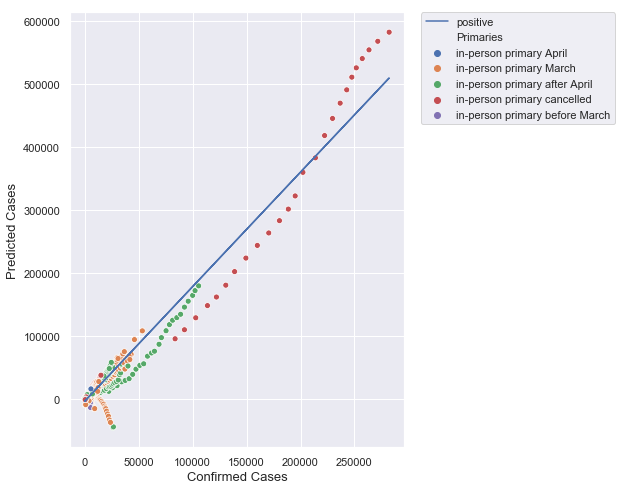

In [99]:
# plot the results
m, b = np.polyfit(actual, predictions, 1)

sns.set(style="darkgrid")
plt.figure(figsize=(6, 8))
ax = plt.axes()
sns.scatterplot(x=actual, y=predictions, hue='Primaries', data=X3_test)
ax.plot(actual, m*actual + b)

ax.set_xlabel('Confirmed Cases', size = 13)
ax.set_ylabel('Predicted Cases', size = 13)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.axis('tight')
plt.show()

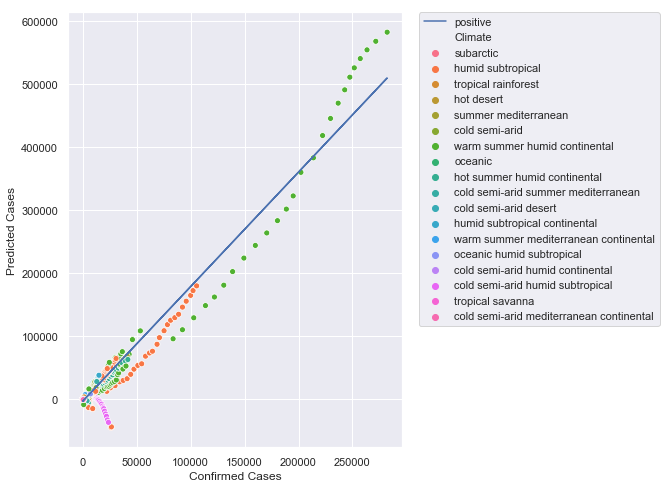

In [100]:
# plot the results
m, b = np.polyfit(actual, predictions, 1)

sns.set(style="darkgrid")
plt.figure(figsize=(6, 8))
ax = plt.axes()
sns.scatterplot(x=actual, y=predictions, hue='Climate', data=X3_test)
ax.plot(actual, m*actual + b)

ax.set_xlabel('Confirmed Cases')
ax.set_ylabel('Predicted Cases')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.axis('tight')
plt.show()

* Compare model to training data with climate and primary features removed

In [101]:
X4 = X3.drop(['Primaries', 'Climate'], axis=1).copy()

In [134]:
X4.head(2)

,Unnamed: 0,ID,state,negative,recovered,death,hospitalized,deathRate,Population Size,Day_num
0,0,2727,WA,0.0,0.0,0.0,0.0,0.0,7614893,1
1,1,2726,WA,0.0,0.0,0.0,0.0,0.0,7614893,2


In [135]:
X4_train = X4[(X4['Day_num']>39) & (X4['Day_num']<=70)]
X4_test = X4[(X4['Day_num']>70) & (X4['Day_num']<=95)]

In [136]:
column_trans2 = make_column_transformer(
    (OneHotEncoder(), ['state']), remainder='passthrough')
column_trans2.fit_transform(X4)
pipe = make_pipeline(column_trans2, lr)

In [137]:
r2_nofeat = cross_val_score(pipe, X4_train, y3_train, cv=5, scoring='r2').mean()

In [138]:
print("The R2 value for positive cases trained on all features is " + str(r2_feat) + 
      " , while the R2 value for positive cases trained without primary and climate data is " +
     str(r2_nofeat))

The R2 value for positive cases trained on all features is -1.9455016173793953 , while the R2 value for positive cases trained without primary and climate data is -1.945595984928234


In [139]:
pipe.fit(X4_train, y3_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['state'])],
                                

In [140]:
pipe.predict(X4_test)

array([  424.20586246,  1210.65228197,   810.20824762, ...,
       15711.85496309,  -585.30548591, -1294.23040933])

In [141]:
predictions2 = pipe.predict(X4_test)
actual2 = y3_test

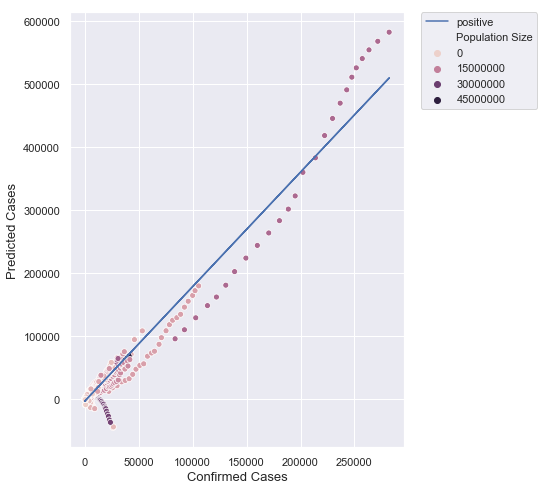

In [142]:
# plot the results of training data without climate and primary features
m, b = np.polyfit(actual2, predictions2, 1)

sns.set(style="darkgrid")
plt.figure(figsize=(6, 8))
ax = plt.axes()
sns.scatterplot(x=actual2, y=predictions2, data=X4_test, hue='Population Size')
ax.plot(actual2, m*actual2 + b)

ax.set_xlabel('Confirmed Cases', size = 13)
ax.set_ylabel('Predicted Cases', size = 13)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.axis('tight')
plt.show()

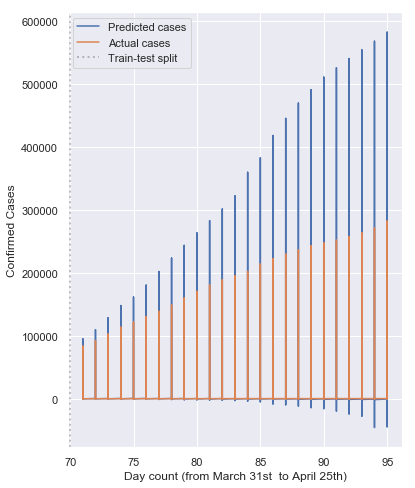

In [146]:
day_num = X4_test['Day_num']
#actual = y3_test
#predictions = X3_test
    
sns.set(style="darkgrid")
plt.figure(figsize=(6, 8))
ax = plt.axes()
ax.plot(day_num, predictions2)
ax.plot(day_num, actual2)
ax.axvline(70, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax.set_xlabel("Day count (from March 31st " + " to April 25th)")
ax.set_ylabel("Confirmed Cases");

###      Train model on individual states and split data on March 31st
*      Train on January - March
*      Test on April

#####    Florida

In [147]:
X_FL = df_reload[(df_reload['state']=='FL')]
#X_FL.head(3)

In [148]:
X_FL_drop = X_FL.drop(['positive', 'Date'], axis=1)

In [149]:
XFL_train = X_FL_drop[(X_FL_drop['Day_num']>39) & (X_FL_drop['Day_num']<=70)]
XFL_test = X_FL_drop[(X_FL_drop['Day_num']>70) & (X_FL_drop['Day_num']<=95)]

In [150]:
yFL_train = X_FL[(X_FL['Day_num']>39) & (X_FL['Day_num']<=70)].positive
yFL_test = X_FL[(X_FL['Day_num']>70) & (X_FL['Day_num']<=95)].positive

In [151]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['state', 'Primaries', 'Climate']), remainder='passthrough')
column_trans.fit_transform(X_FL_drop)
pipe = make_pipeline(column_trans, lr)

In [152]:
r2_feat_FL = cross_val_score(pipe, XFL_train, yFL_train, cv=5, scoring='r2').mean()
r2_feat_FL

-45.5242319370151

In [153]:
r2_MSE_FL = cross_val_score(pipe, XFL_train, yFL_train, cv=5, scoring='neg_mean_squared_error').mean()
r2_MSE_FL

-27455.48735585771

In [154]:
pipe.fit(XFL_train, yFL_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['state', 'Primaries',
                      

In [155]:
pipe.predict(XFL_test)

array([ 6680.52904609,  8522.80421287, 10504.83949046, 11884.84367604,
       13474.71253503, 14653.52172232, 17182.05324593, 17865.02773262,
       19657.01156231, 21228.79617084, 23216.45122791, 24677.7067569 ,
       26265.83404483, 28066.4092915 , 30583.54148354, 31981.00400839,
       34565.00039987, 36884.15383104, 38367.62122077, 39868.16160503,
       41918.76299197, 44142.97267833, 46509.45010599, 49513.37006039,
       52016.15793913])

In [156]:
predictions_FL = pipe.predict(XFL_test)
actual_FL = yFL_test

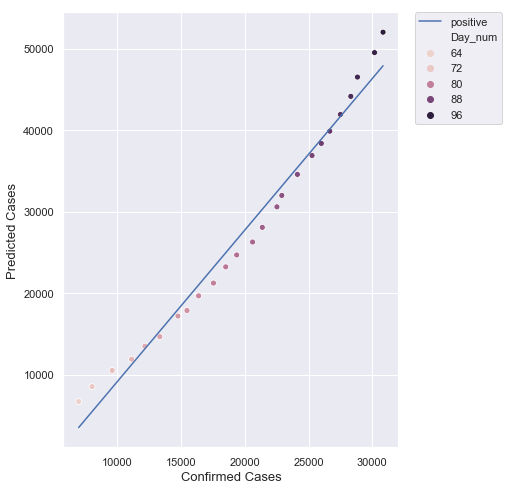

In [157]:
# plot the results
m, b = np.polyfit(actual_FL, predictions_FL, 1)

sns.set(style="darkgrid")
plt.figure(figsize=(6, 8))
ax = plt.axes()
sns.scatterplot(x=actual_FL, y=predictions_FL, data=XFL_test, hue='Day_num')
ax.plot(actual_FL, m*actual_FL + b)

ax.set_xlabel('Confirmed Cases', size = 13)
ax.set_ylabel('Predicted Cases', size = 13)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.axis('tight')
plt.show()

#####    New York

In [158]:
X_NY = df_reload[(df_reload['state']=='NY')]
X_NY_drop = X_NY.drop(['positive', 'Date'], axis=1)
XNY_train = X_NY_drop[(X_NY_drop['Day_num']>39) & (X_NY_drop['Day_num']<=70)]
XNY_test = X_NY_drop[(X_NY_drop['Day_num']>70) & (X_NY_drop['Day_num']<=95)]
yNY_train = X_NY[(X_NY['Day_num']>39) & (X_NY['Day_num']<=70)].positive
yNY_test = X_NY[(X_NY['Day_num']>70) & (X_NY['Day_num']<=95)].positive
column_trans.fit_transform(X_NY_drop)
pipe = make_pipeline(column_trans, lr)

In [159]:
r2_feat_NY = cross_val_score(pipe, XNY_train, yNY_train, cv=5, scoring='r2').mean()
r2_feat_NY

-106.74485635840531

In [160]:
r2_MSE_NY = cross_val_score(pipe, XNY_train, yNY_train, cv=5, scoring='neg_mean_squared_error').mean()
r2_MSE_NY

-31851392.279687304

In [161]:
print("The R2 value for the Florida model is " + str(r2_feat_FL) + 
      " , while the R2 value for the New York model is " +
     str(r2_feat_NY))

The R2 value for the Florida model is -45.5242319370151 , while the R2 value for the New York model is -106.74485635840531


In [162]:
print("The mean squared error for the Florida model is " + str(r2_MSE_FL) + 
      " , while the mean squared error for the New York model is " +
     str(r2_MSE_NY))

The mean squared error for the Florida model is -27455.48735585771 , while the mean squared error for the New York model is -31851392.279687304


In [163]:
pipe.fit(XNY_train, yNY_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['state', 'Primaries',
                      

In [164]:
pipe.predict(XNY_test)

array([ 87102.89388498,  98766.97897536, 113429.99124163, 129338.6414067 ,
       143034.47771046, 157278.67789853, 173835.73669997, 192535.37836747,
       211649.06146316, 230482.25279424, 248263.37819116, 265401.1532559 ,
       279623.21328632, 299859.33499092, 316869.0385175 , 335827.20077467,
       352752.1730258 , 368464.33603493, 382722.31802686, 395386.52626502,
       406686.65845622, 419140.12613402, 432516.91372884, 447916.15435427,
       466783.36968659])

In [165]:
predictions_NY = pipe.predict(XNY_test)
actual_NY = yNY_test

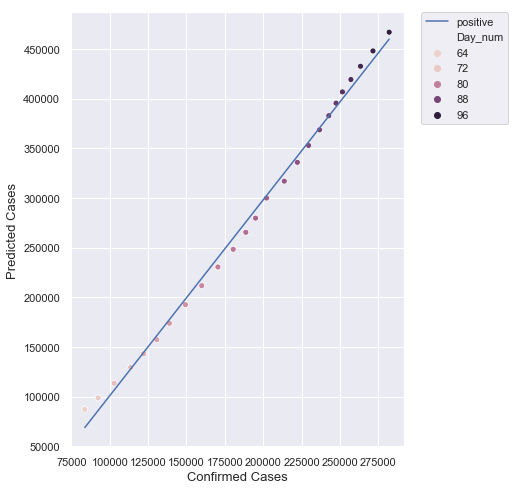

In [166]:
# plot the results
m, b = np.polyfit(actual_NY, predictions_NY, 1)

sns.set(style="darkgrid")
plt.figure(figsize=(6, 8))
ax = plt.axes()
sns.scatterplot(x=actual_NY, y=predictions_NY, data=XNY_test, hue='Day_num')
ax.plot(actual_NY, m*actual_NY + b)

ax.set_xlabel('Confirmed Cases', size = 13)
ax.set_ylabel('Predicted Cases', size = 13)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.axis('tight')
plt.show()